In [1]:
import numpy as np
import pandas as pd
import splat
import popsims
from astropy.coordinates import SkyCoord, Galactic
import astropy.coordinates as astro_coord
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
#sns.set_style("darkgrid", {"axes.facecolor": ".95"})

#plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')
#sns.set_style("dark")

from  matplotlib.colors import Normalize
import astropy.units as u
import popsims
import matplotlib
from tqdm import tqdm
from tqdm import tqdm
import matplotlib as mpl 
#mpl.rcParams['axes.labelsize'] = 20
#mpl.rcParams['xtick.labelsize'] =20
#mpl.rcParams['ytick.labelsize'] = 20
#mpl.rcParams['legend.fontsize'] = 20
#mpl.rcParams['figure.titlesize'] = 20
from astropy.coordinates import Angle
import astropy.table as astrotable

splat.initializeStandards(all=True)
from scipy.interpolate import griddata, interpn
import splat.empirical as spe
%matplotlib inline




Welcome to the Spex Prism Library Analysis Toolkit (SPLAT)!
If you make use of any features of this toolkit for your research, please remember to cite the SPLAT paper:

Burgasser et al. (2017, Astro. Soc. India Conf. Series 14, p. 7); Bibcode: 2017ASInC..14....7B

If you make use of any spectra or models in this toolkit, please remember to cite the original source.
Please report any errors are feature requests to our github page, https://github.com/aburgasser/splat/




In [2]:
PS1_DEPTHS={ 'Y':21.4} #'R':23.2, 'I':23.1  'Z':22.3 something funny happening
SDSS_DEPTHS={'Z':20.5} #R':22.2, 'I':21.3,
VISTA_DEPTHS={'KS':17.9} #'J':19.5, 'H':18.6,
color_cuts={#'SDSS_G-SDSS_R':(1.6, 'greater'),
            #'SDSS_R-SDSS_I': (1.0, 'greater'),
            #'SDSS_I-SDSS_Z': (0.5, 'greater'),
            #'SDSS_R-SDSS_Z': (1.6, 'greater'),
            #'SDSS_I-VISTA_J':(1.7, 'greater'),
            'SDSS_Z-VISTA_J':(1.1, 'greater'),
            'VISTA_J-VISTA_KS':(0.75, 'less')} 
OTHER_CUTS={#'SDSS_R': 22.2, 
           #'SDSS_I': 21.3,
            #'PANSTARRS_R': 23.2,
            #'PANSTARRS_I':23.1,
            #'PANSTARRS_Z':22.3,
            'VISTA_J':19.3,
            'VISTA_H':18.6}

In [3]:
#SDSS 
SDSS={'FOV': 2.5*u.degree*2.5*u.degree,\
      'l':((np.array([0, 360]))*u.degree.to(u.radian)),\
            'b': ((np.array([-90, 90]))*u.degree.to(u.radian))}

SDSS_discrete={'FOV': 2.5*u.degree*2.5*u.degree,\
      'l':((np.array([0, 360]))*u.degree.to(u.radian)),\
            'b': ((np.array([-90, 90]))*u.degree.to(u.radian))}

In [4]:
#DATA_FOLDER='/volumes/Lacie/popsimsdata//'

In [5]:
#t1    = astrotable.Table.read(DATA_FOLDER+'Stripe_Defs6_ctheissen.fit') # open an FITS file
#t2    = astrotable.Table.read(DATA_FOLDER+'FieldNums_ctheissen.fit') # open an FITS file
#t3    = astrotable.join(t1, t2, keys='fieldid').to_pandas()

In [6]:
import glob

In [7]:
from astropy.io.votable import parse_single_table

In [8]:
#forget about sdss use
ffolder='/volumes/LaCie/lodieu/*.xml'
lodieu_dfs=[]
for f in glob.glob(ffolder):
    tbl = parse_single_table(f).to_table()
    print('Number of candidates',len(tbl))
    lodieu_dfs.append(tbl.to_pandas())
dfl_conct=pd.concat(lodieu_dfs)

Number of candidates 130
Number of candidates 4
Number of candidates 114
Number of candidates 59
Number of candidates 52
Number of candidates 174
Number of candidates 17
Number of candidates 115
Number of candidates 13
Number of candidates 445
Number of candidates 2
Number of candidates 253


In [9]:
#combine 
ras0=np.nanmedian([dfl_conct['RAJ2000_VHS'].values, dfl_conct['RAJ2000_LAS'].values], axis=0)
decs0=np.nanmedian([dfl_conct['DEJ2000_VHS'].values, dfl_conct['DEJ2000_LAS'].values], axis=0)

In [10]:
assert len(popsims.dropnans(ras0)) == len(dfl_conct)
assert len(popsims.dropnans(decs0)) == len(dfl_conct)

In [11]:
footprint=SkyCoord(ra=ras0*u.degree, dec=decs0*u.degree)

In [12]:
a=Angle(footprint.ra.to(u.radian))
b=Angle(footprint.dec.to(u.radian))
a.wrap_at('180d', inplace=True)
b.wrap_at('180d', inplace=True)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 


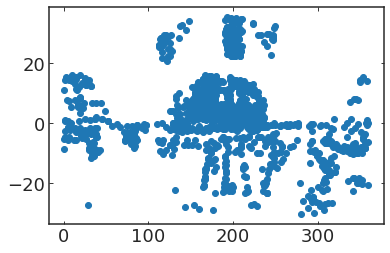

In [13]:
fig, ax=plt.subplots()
ax.scatter(ras0, decs0)

In [14]:
def interpolated(ra, dec, interpolators):
    #Ra dec must in degrees wrapped at 180 degree
    interpoints=np.array([interpolators[0], interpolators[1] ]).T
    return griddata(interpoints, interpolators[-1] , (ra, dec), \
                    method='cubic', fill_value=-1.)
def interpolated_broken(ra, dec,interpolators):
    interpoints=np.array([interpolators[0], interpolators[1] ])
    return  interpn(list(zip(interpoints)), interpolators[-1] , (ra, dec),\
                     fill_value=-1.,  bounds_error=False) 

In [15]:
#from popsims.widefields import  WideField, create_mixed_population,\
#transform_tocylindrical

In [16]:
#field= WideField(footprinttype='uniform')
#field.footprint=SDSS
#trace=field.sample_points(nsample=1e5, Hthin=350, dmin=1, dmax=1000)

In [17]:
thin_dist_list=[]
thick_dist_list=[]
halo_dist_list=[]
discr_ls=[]
discr_bs=[]

for i in tqdm(np.arange(1000)):
    c=sdsscoord[np.random.choice(len(sdsscoord))]
    narro_field=popsims.Pointing(coord=c)
    halo_field=popsims.Pointing(coord=c, density='spheroid')

    narro_field.mag_limits=dict(zip(['VISTA_{}'.format(k) for k in VISTA_DEPTHS.keys()],\
             [(0, VISTA_DEPTHS[k]) for k in VISTA_DEPTHS.keys()]))
    thin_dist_list +=list(narro_field.draw_distances(0.1, 1000,350,  nsample=1e3))
    thick_dist_list +=list(narro_field.draw_distances(0.1, 1000,900,  nsample=1e3))
    halo_dist_list +=list(halo_field.draw_distances(0.1, 1000,900,  nsample=1e3))
    discr_ls += [c.galactic.l.value]
    discr_bs += [c.galactic.b.value]

In [18]:
#np.save('/volumes/LaCie/popsimsdata/lodieupaper_distances.npy',\
#        {'thind':thin_dist_list ,\
#         'thickd':thick_dist_list ,\
#         'halod': halo_dist_list,\
#         'l': discr_ls ,\
#         'b': discr_bs}, allow_pickle=True)

In [19]:
grid=np.arange(14, 40)

In [20]:
dictionary=np.load('/volumes/LaCie/popsimsdata/lodieupaper_distances.npy', allow_pickle=True)
dist_dictionary=dictionary.flatten()[0]
thin_dist_list= dist_dictionary['thind']
thick_dist_list= dist_dictionary['thickd']
halo_dist_list= dist_dictionary['halod']
discr_ls = dist_dictionary['l']
discr_bs = dist_dictionary['b']

In [21]:
from popsims import galaxy

In [22]:
max_distances={}
for g in grid:
    pol=galaxy.POLYNOMIALS['absmags']['dwarfs']['VISTA_J']['fit']
    max_distances[g]=galaxy.get_distance(pol(g), 19.5)

In [23]:
max_distances

{14: 1279.0694890106447,
 15: 958.0806620206615,
 16: 737.5505586463466,
 17: 581.6612397596215,
 18: 468.4074143054953,
 19: 384.0254409775539,
 20: 319.7501672164548,
 21: 269.8982952879229,
 22: 230.7145440728559,
 23: 199.66372573352987,
 24: 174.9891543630689,
 25: 155.4334950279863,
 26: 140.0596177774378,
 27: 128.13169572384982,
 28: 119.02935053358857,
 29: 112.17505931522875,
 30: 106.96069371527251,
 31: 102.6667199422274,
 32: 98.38299055604526,
 33: 92.97058860538125,
 34: 85.1512263203001,
 35: 73.84636736852276,
 36: 58.82200176029963,
 37: 41.39901147561286,
 38: 24.52893977454304,
 39: 11.530423583423294}

In [24]:
def resample_distance(df, dmax_dict, population ):
    df['d']=np.nan
    if population=='thin_disk':
        ds=np.array(thin_dist_list)
    if population=='thick_disk':
        ds=np.array(thick_dist_list)
    if population=='halo':
        ds=np.array(halo_dist_list)
    ds=np.array(ds)
    df['spt_r']=np.round(df.spt)
    
    dx= ds[ds< dmax_dict[float(df.spt_r.iloc[0])] ]
    df['d']= np.random.choice(dx, len(df))
    return df
def sample_distance_properly(df, dmax_dict, population='thin_disk'):
    df['spt_r']=np.round(df.spt)
    groups=[]
    for g in tqdm( df.groupby('spt_r')):
        groups.append(resample_distance(g[1], dmax_dict, population))
    return pd.concat(groups)
def interpolate_sdss(ra, dec):
    interpolators=[a.to(u.degree).value, b.to(u.degree).value, np.ones_like(a)]
    return interpolated(ra, dec, interpolators )
def apply_sdss_selection(df):
    entiregalaxy=SkyCoord(l=df.l*u.radian,\
                     b=df.b*u.radian, frame='galactic')
    
    gridra=Angle(entiregalaxy.icrs.ra.to(u.radian))
    gridra.wrap_at('180d', inplace=True)
    griddec=Angle(entiregalaxy.icrs.dec.to(u.radian))
    griddec.wrap_at('180d', inplace=True)

    selectionfunction=interpolate_sdss(gridra.to(u.degree).value, \
                                                  griddec.to(u.degree).value)
    df['SDSS_selection']= selectionfunction
    df['ra']=gridra
    df['dec']=griddec
    return df

def apply_color_cuts(df):
    bools=[]
    for k in color_cuts.keys():
        xkey, ykey= k.split('-')
        if color_cuts[k][-1]=='greater':
            bools.append(df['abs_{}'.format(xkey)]-df['abs_{}'.format(ykey)] >= color_cuts[k][0])
        if color_cuts[k][-1]=='less':
            print (k)
            bools.append(df['abs_{}'.format(xkey)]-df['abs_{}'.format(ykey)] <= color_cuts[k][0])
    return np.logical_and.reduce(bools)
    

In [25]:
mag_keys0=['VISTA_Z', 'VISTA_Y', 'VISTA_J', 'VISTA_H', 'VISTA_KS', 'UKIDSS_Z', \
 'UKIDSS_J', 'UKIDSS_H', 'UKIDSS_K']

In [26]:
def apply_all_magnitude_color_cuts(df):
    other_bools=[]
    for k in PS1_DEPTHS.keys():
        other_bools.append((df['PANSTARRS_{}'.format(k)]<PS1_DEPTHS[k]).values)
    for k in SDSS_DEPTHS.keys():
        other_bools.append((df['SDSS_{}'.format(k)]<SDSS_DEPTHS[k]).values)
    for k in VISTA_DEPTHS.keys():
        other_bools.append((df['VISTA_{}'.format(k)]<VISTA_DEPTHS[k]).values)
    tot_bools=np.logical_and.reduce(other_bools)
    #
    
    return tot_bools

In [27]:
def sample_distance_from_d3(dmax, nsample):
    ##random choice from d^3
    d=np.linspace(0.1, dmax, 1000)
    cdf=(d**3)/np.nanmax(d**3)
    return popsims.tools.random_draw(d, cdf, nsample=nsample)

In [28]:
#

In [29]:
#redra ibjects from halo thin or thick based on the max dista
def resample_by_max_distance(nsample=1e4):
    df_list=[]
    for k in max_distances.keys():
        if max_distances[k] >200:
            #make distance array array
            thin_dist_list_arr=np.array(thin_dist_list)
            thick_dist_list_arr=np.array(thick_dist_list)
            halo_dist_list_arr=np.array(halo_dist_list)
        else:
            thin_dist_list_arr=sample_distance_from_d3(2*max_distances[k], int(1e5))
            thick_dist_list_arr=sample_distance_from_d3(2*max_distances[k], int(1e5))
            halo_dist_list_arr=sample_distance_from_d3(2*max_distances[k], int(1e5))
        
        
        #use metal-rich models but absolute mag relations for metal poor
        df_thin=galaxy.create_pop(bfraction=0.2,\
                         model='burrows1997',\
                             l=discr_ls, b=discr_bs,\
                           absmag_keys=mag_keys0, \
                      nsample=2*nsample, \
            distances= thin_dist_list_arr[thin_dist_list_arr<2*max_distances[k]],\
                  poptype='dwarfs')
        
        df_thick=galaxy.create_pop(bfraction=0.2,\
                          model='burrows1997',\
                             l=discr_ls, b=discr_bs,\
                           absmag_keys=mag_keys0, \
                      nsample=2*nsample, \
        distances= thick_dist_list_arr[thick_dist_list_arr<2*max_distances[k]],\
                         population='thick_disk', poptype='subdwarfs')
        
        df_halo=galaxy.create_pop(bfraction=0.2,\
                         model='burrows1997',\
                             l=discr_ls, b=discr_bs,\
                           absmag_keys=mag_keys0, \
                      nsample=2*nsample,\
        distances= halo_dist_list_arr[halo_dist_list_arr<2*max_distances[k]],\
                         population='halo', poptype='subdwarfs')
        
        df_thin['population']='thin_disk'
        df_thick['population']='thick_disk' 
        df_halo['population']='halo'
        
        #make magnitudes and distance cuts righ aay
        thin_bool=np.logical_and.reduce([df_thin.spt>=k, df_thin.spt<k+1, \
                                         df_thin.d <2*max_distances[k]])
                                        #apply_all_magnitude_color_cuts(df_thin)])
        
        thick_bool=np.logical_and.reduce([df_thick.spt>=k, df_thick.spt<k+1, \
                                         df_thick.d <2*max_distances[k]])
                                         # apply_all_magnitude_color_cuts(df_thick)])
        
        halo_bool=np.logical_and.reduce([df_halo.spt>=k, df_halo.spt<k+1, \
                                         df_halo.d <2*max_distances[k]])
                                       #  apply_all_magnitude_color_cuts(df_halo)])
        
        print ('thin for spt {} {}'.format(k, len(df_thin.loc[thin_bool])))
        print ('thick for spt {} {}'.format(k, len(df_thick.loc[thick_bool])))
        print ('halo for spt {} {}'.format(k, len(df_halo.loc[halo_bool])))
        df_thin_small_df=(df_thin.loc[thin_bool]).reset_index(drop=True)
        df_thick_small_df=(df_thick.loc[thick_bool]).reset_index(drop=True)
        df_halo_small_df=(df_halo.loc[halo_bool]).reset_index(drop=True)
        
        df_list.append(pd.concat([df_thin_small_df.sample(n=int(nsample), replace=True), \
              df_thick_small_df.sample(n=int(nsample), replace=True), \
              df_halo_small_df.sample(n=int(nsample), replace=True)]).reset_index(drop=True))
        
        del df_thin_small_df
        del df_thick_small_df
        del df_halo_small_df
        
    df0=pd.concat(df_list)
    #use SD relations from Rocio for 
    df=galaxy.pop_mags_from_type(df0.spt.values, d=df0.d.values, \
                keys=['SDSS_R', 'SDSS_I', 'SDSS_Z'], reference='kiman2019').join(df0, rsuffix='_rocio')
    df=df.drop(['abs_SDSS_R', 'abs_SDSS_I', 'abs_SDSS_Z', 'SDSS_R', 'SDSS_I', 'SDSS_Z'], axis=1).rename(columns={'SDSS_R_rocio': 'SDSS_R',\
               'abs_SDSS_R_rocio': 'abs_SDSS_R',\
               'SDSS_I_rocio': 'SDSS_I',\
               'abs_SDSS_I_rocio': 'abs_SDSS_I',\
               'SDSS_Z_rocio': 'SDSS_Z',\
               'abs_SDSS_Z_rocio': 'abs_SDSS_Z'}).reset_index(drop=True)
    
    #use default stuff for 2MASS 
    df['abs_2MASS_J']=spe.typeToMag(df.spt.values, '2MASS J')[0]
    df['abs_2MASS_H']=spe.typeToMag(df.spt.values, '2MASS H')[0]
    df['abs_2MASS_K']=spe.typeToMag(df.spt.values, '2MASS K')[0]
    df['2MASS_J']=df.abs_2MASS_J+5*np.log10(df.d/10.0)
    df['2MASS_H']=df.abs_2MASS_H+5*np.log10(df.d/10.0)
    df['2MASS_K']=df.abs_2MASS_K+5*np.log10(df.d/10.0)

    #Add
    sd_bool=(df.population != 'thin_disk').values
    for k in ['SDSS_Z', 'SDSS_R', 'SDSS_Z', '2MASS_J', '2MASS_H', '2MASS_KS']:

        df.loc[sd_bool, 'abs_{}'.format(k)]= (spe.typeToMag(df.spt.values[sd_bool], \
                                              k,  reference='zhang2013')[0])
        df.loc[sd_bool, k]=df.loc[sd_bool, 'abs_{}'.format(k)]+5*np.log10(df.d.loc[sd_bool]/10.0)
    
    df['spt_r']=df.spt.apply(np.round)
    color_bools=apply_color_cuts(df)
    other_bools=[]
    for k in OTHER_CUTS.keys():
        other_bools.append((df[k]<OTHER_CUTS[k]).values)
    tot_bools=np.logical_and.reduce(other_bools)
    tot_bools=np.logical_and(color_bools, tot_bools)
    dfn=(df.loc[color_bools]).reset_index(drop=True)
    return dfn



In [30]:
dfn=resample_by_max_distance(nsample=5e4)

thin for spt 14 11018
thick for spt 14 10873
halo for spt 14 10715
thin for spt 15 9338
thick for spt 15 9150
halo for spt 15 9167
thin for spt 16 5986
thick for spt 16 5714
halo for spt 16 5712
thin for spt 17 2597
thick for spt 17 2082
halo for spt 17 2144
thin for spt 18 1351
thick for spt 18 908
halo for spt 18 942
thin for spt 19 1395
thick for spt 19 843
halo for spt 19 889
thin for spt 20 1354
thick for spt 20 870
halo for spt 20 833
thin for spt 21 1207
thick for spt 21 838
halo for spt 21 877
thin for spt 22 1148
thick for spt 22 726
halo for spt 22 728
thin for spt 23 1403
thick for spt 23 660
halo for spt 23 637
thin for spt 24 1673
thick for spt 24 483
halo for spt 24 459
thin for spt 25 1674
thick for spt 25 357
halo for spt 25 345
thin for spt 26 1512
thick for spt 26 332
halo for spt 26 318
thin for spt 27 1291
thick for spt 27 321
halo for spt 27 251
thin for spt 28 1188
thick for spt 28 273
halo for spt 28 249
thin for spt 29 1270
thick for spt 29 318
halo for spt 29 3

In [31]:
len(dfn)

387070

In [32]:
len(dfn)

387070

In [33]:
#dfn=dfn.sample(n=int(1e5), replace=True )
#dfn=df.sample(n= int(1e4), replace=True )

[Text(0.5, 0, 'Distance')]

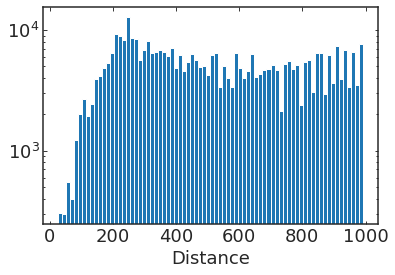

In [34]:
fig, ax=plt.subplots()
h=plt.hist(dfn.d, bins='auto', log=True)
ax.set(xlabel='Distance')

In [35]:
for g in dfn.groupby('spt_r'):
    print (g[0], len(g[1]))

14.0 25763
15.0 26108
16.0 58570
17.0 21462
18.0 37329
19.0 25695
20.0 26997
21.0 28425
22.0 24938
23.0 22552
24.0 20809
25.0 19388
26.0 19339
27.0 21626
28.0 8069


In [36]:
halo_bool=(dfn.population !='thin_disk').values

In [37]:
mags= galaxy.pop_mags_from_type(np.random.uniform(10, 40, 1000),
                keys=['SDSS_R', 'SDSS_I', 'SDSS_Z'], reference='kiman2019')

In [38]:
#mags

In [39]:
zhang_mags={}
for k in ['SDSS_R', 'SDSS_I', 'SDSS_Z']:
    zhang_mags[k]=spe.typeToMag(np.random.uniform(10, 40, 1000), k,  reference='zhang2013')[0]

In [40]:
zhang_mags=pd.Series(zhang_mags)

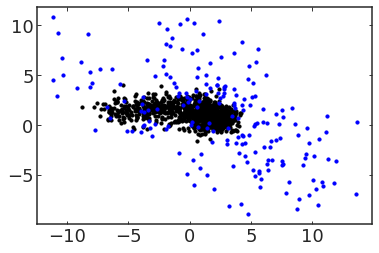

In [41]:
fig, ax=plt.subplots()
ax.scatter(mags.abs_SDSS_R-mags.abs_SDSS_I, \
           mags.abs_SDSS_I-mags.abs_SDSS_Z,s=10, c='k')

ax.scatter(zhang_mags.SDSS_R-zhang_mags.SDSS_I, \
           zhang_mags.SDSS_I-zhang_mags.SDSS_Z,s=10, c='b')


#ax.set(xlabel='r-i', ylabel='i-z', xlim=[0, 3], ylim=[0,3])


In [42]:
#dfn

In [43]:
dfn_coord=SkyCoord(l=dfn.l*u.degree, b=dfn.b*u.degree, frame='galactic')

In [44]:
dfn['ra']=dfn_coord.icrs.ra.to(u.degree)
dfn['dec']=dfn_coord.icrs.dec.to(u.degree)

In [48]:
dfn['ra']

0         150.811196
1         194.905890
2         190.439925
3         178.970601
4         176.093754
             ...    
387065    228.313491
387066    101.522159
387067    302.142409
387068    194.021249
387069    332.708045
Name: ra, Length: 387070, dtype: float64

In [ ]:
tqdm.pandas()
motion_df=dfn[['ra', 'dec', 'd', 'U', 'V', \
       'W' ]].progress_apply(lambda x: galaxy.get_proper_motion(*x), axis=1).reset_index(drop=True)

In [ ]:
motion_halo=pd.DataFrame( popsims.galaxy.get_proper_motion_cylindrical(dfn.ra.values, \
                             dfn.dec.values,
                            (dfn.d.values)/1000,
                             dfn.Vr.values,
                            (dfn.Vphi.values)/(dfn.d.values+8300.*u.pc.to(u.km)),
                            dfn.Vz.values))

In [ ]:
#len(dfj)==len(dfn)

In [ ]:
dfn=dfn.reset_index(drop=True)

In [ ]:
dfj=dfn.join(motion_df).reset_index(drop=True)

In [ ]:
halo_bool=dfj.population=='halo'

In [ ]:
#computer proper motions for halo star
dfj.loc[halo_bool, 'RV'] = motion_halo[halo_bool]['RV'].values
dfj.loc[halo_bool, 'mu_alpha'] = motion_halo[halo_bool]['mu_alpha'].values
dfj.loc[halo_bool, 'mu_delta']= motion_halo[halo_bool]['mu_delta'].values

In [ ]:
fig, ax=plt.subplots()
for k in PS1_DEPTHS.keys():
    #h=plt.hist(df['PANSTARRS_{}'.format(k)], bins='auto', histtype='step',\
    #           lw=2, log=True, linestyle='--')
    h=plt.hist(dfn['PANSTARRS_{}'.format(k)].values, bins='auto',\
               histtype='step', lw=2, log=True)

In [ ]:
dfj.columns

In [ ]:
for k in [ '2MASS_J', '2MASS_H', 'VISTA_J', 'VISTA_H']:
    dfj['redH_{}'.format(k)]=dfj['abs_{}'.format(k)]+\
     5*np.log10((dfj.mu_alpha**2+ dfj.mu_delta**2)**0.5)+5

In [ ]:
fig, ax=plt.subplots()
for k in [ '2MASS_J', '2MASS_H', 'VISTA_J', 'VISTA_H']:
    vals=dfj['redH_{}'.format(k)].values
    h=plt.hist(popsims.dropnans(vals),\
               bins='auto', histtype='step', lw=2, 
               log=True, label=k, range=[0, 30])
plt.legend(fontsize=14)
ax.set(xlabel='Reduced Proper Motion')

In [ ]:
fig, ax=plt.subplots()

h=ax.scatter((dfj.mu_alpha**2+ dfj.mu_delta**2)**0.5, dfj.d,  c=dfj.spt, s=1, alpha=0.5)
ax.set(xscale='log', yscale='log', xlabel='Proper motion (mas/yr)', \
       ylabel='Distance (pc)', )

In [ ]:
#(dfj['VISTA_J']-dfj['VISTA_KS']).min()

In [ ]:
### color-color plots
fig, ax=plt.subplots(figsize=(12, 4), ncols=3)


ax[0].scatter((dfj.SDSS_I[dfj.population=='thick_disk']-\
                dfj['VISTA_J'][dfj.population=='thick_disk']), \
           dfj['redH_{}'.format('VISTA_J')][dfj.population=='thick_disk'], s=10, \
           label='thick disk', marker='*')
ax[0].scatter((dfj.SDSS_I[dfj.population=='halo']-\
            dfj['VISTA_J'].loc[dfj.population=='halo']), \
           dfj['redH_{}'.format('VISTA_J')].loc[dfj.population=='halo'], \
           s=10, label='halo stars', color='r',
              marker='D')
ax[0].scatter((dfl_conct.SDSSi-dfl_conct.Jmag_VHS).values, \
                dfl_conct.Hj, s=5, c='k', label='Crossmatches')



ax[1].scatter((dfj.SDSS_Z[dfj.population=='thick_disk']-\
                dfj.VISTA_J[dfj.population=='thick_disk']), 
          (dfj.VISTA_J[dfj.population=='thick_disk']-\
                dfj.VISTA_KS[dfj.population=='thick_disk']),
           label='thick disk')
ax[1].scatter((dfj.SDSS_Z[dfj.population=='halo']-\
                dfj.VISTA_J[dfj.population=='halo']), 
          (dfj.VISTA_J[dfj.population=='halo']-\
                dfj.VISTA_KS[dfj.population=='halo']),
           s=10, label='halo stars', color='r',
              marker='D')
ax[1].scatter((dfl_conct.SDSSz-dfl_conct.Jmag_VHS).values, \
              (dfl_conct.Jmag_VHS-dfl_conct.Kmag_VHS).values, s=5, c='k', label='Crossmatches')



ax[-1].scatter((dfj.SDSS_I[dfj.population=='thick_disk']-\
                dfj.SDSS_Z[dfj.population=='thick_disk']), 
          (dfj['VISTA_J'][dfj.population=='thick_disk']-\
                dfj['VISTA_KS'][dfj.population=='thick_disk']),
           label='thick disk')
ax[-1].scatter((dfj.SDSS_I[dfj.population=='halo']-\
                dfj.SDSS_Z[dfj.population=='halo']), 
          (dfj['VISTA_J'][dfj.population=='halo']-\
                dfj['VISTA_KS'][dfj.population=='halo']),
           s=10, label='halo stars', color='r',
              marker='D')
ax[-1].scatter((dfl_conct.SDSSi-dfl_conct.SDSSz).values, \
              (dfl_conct.Jmag_VHS-dfl_conct.Kmag_VHS).values, s=5, c='k', \
               label='Crossmatches')

ax[0].set(xlabel='i-J',ylabel=r'H$_J$', xlim=[1., 9], ylim=[30, 15])
ax[0].axvline(1.9, color='k', linestyle='--')
ax[1].set(xlabel='z-J', ylabel='J-K', xlim=[0, 5], ylim=[-1.5, 1.5])
ax[-1].set(xlabel='i-z', ylabel='J-K', xlim=[0, 3], ylim=[-1, 1.2])

plt.tight_layout()
plt.savefig(popsims.FIGURES+'/simulatedcolors_sdss_vhs.pdf')

In [ ]:
#

In [ ]:
dfj['selection_function']=1.

In [ ]:
#df['selection_function']=tot_bools

In [ ]:
def get_ncounts(binby='spt', grid=np.arange(15, 40),
               population='thin_disk', df=None):
    
    df=(df[df.population==population]).reset_index(drop=True)
    scale=[df.scale.mean(), df.scale_unc.mean(),df.scale_times_model.mean()]
    NSIM=dict(zip(grid, np.zeros((len(grid), 2))))
    
    df['r_{}'.format(binby)]=df[binby].apply(np.round)
    df=df[df['r_{}'.format(binby)].isin(grid)].reset_index(drop=True)

    for g in tqdm(df.groupby('r_{}'.format(binby))):
        
        sn= len(df[np.logical_and(df.temperature>=450, df.temperature<=2100)])
        n0=scale[-1]/scale[0]
        #print (n0)
        scln=np.array([scale[0]*n0/sn,\
                       (scale[1]*scale[-1])/(sn*scale[0])])
        
        #if sd:
        #    b0=np.logical_and(df.temperature>=450, df.temperature<=2100)
        #    b1=df.population=='halo'
        #    nhalo=len(df[np.logical_and(b0, b1)])/sn
        #    scln=scln*nhalo

        
        #assert scln[0] > scale[0]
        NSIM[g[0]]=np.nansum(g[1].selection_function)*scln
    df.drop('r_{}'.format(binby), axis=1)
    return pd.DataFrame(NSIM).T.rename(columns={0: 'N', 1: 'Nunc'})

In [ ]:
 #dfj

In [ ]:

counts=get_ncounts(grid=grid, population='thin_disk', df=dfj)
thickcounts=get_ncounts(grid=grid,  population='thick_disk', df=dfj)
halocounts=get_ncounts(grid=grid,  population='halo', df=dfj)

In [ ]:
#halocounts

In [ ]:
import scipy.integrate as integrate

In [ ]:
def compute_volume(spt, l, b, h=350):
    dmin=0
    dmax=max_distances[spt]
    if np.isnan(dmax):
        return np.nan
    else:
        ds=np.linspace(dmin, dmax, 1000)
        rd=np.sqrt( (ds * np.cos( b ) )**2 + popsims.Rsun * (popsims.Rsun - 2 * ds * np.cos( b ) * np.cos( l ) ) )
        zd=popsims.Zsun+ ds * np.sin( b - np.arctan( popsims.Zsun / popsims.Rsun) )
        rh=popsims.galactic_density(rd, zd, h)
        return {'thin': integrate.trapz(rh['thin']*(ds**2), x=ds), \
                'thick': integrate.trapz(rh['thick']*(ds**2), x=ds), \
                'halo': integrate.trapz(rh['halo']*(ds**2), x=ds)}
                

In [ ]:
grid

In [ ]:
volumes={}
for k in grid:
    vs={'thin': 0.0, 'thick': 0.0, 'halo': 0.0}
    for f in tqdm(footprint):
        l=f.galactic.l.radian
        b=f.galactic.b.radian
        v=compute_volume(k, l, b, h=350)
        vs['thin'] +=v['thin']
        vs['thick'] +=v['thick']
        vs['halo'] +=v['halo']
    volumes[k]=vs

In [ ]:
#save this, takes too much time to do
volumes_df=pd.DataFrame(volumes).T/len(footprint)

In [ ]:
area=5350*(u.degree**2).to(u.radian**2)*(u.radian**2)
area_to_degree=area.to(u.degree**2)

In [ ]:
area_to_degree

In [ ]:
#volumes

In [ ]:
#easiest ay is to compute volumes for every field and then
#second easiest thing, simulate an entire sky and do 2d-interpolation over sdss area

In [ ]:
#counts['volume']=pd.Series(volumes).T/len(dfn_coord)
#sdcounts['volume']=pd.Series(volumes).T/len(dfn_coord)

In [ ]:
counts.N.median()

In [ ]:
fig, ax=plt.subplots()
volumes_df.thin.apply(np.log10).plot(label='thin', ax=ax)
volumes_df.thick.apply(np.log10).plot(label='thick', ax=ax)
volumes_df.halo.apply(np.log10).plot(label='halo', ax=ax)
ax.legend()
ax.set(ylabel=r'N/radian$^2$')



In [ ]:
fig, ax=plt.subplots(figsize=(8, 5))

ax.step(counts.index, (counts.N.values*volumes_df.thin.values*area.value/(area)).to(u.deg**-2), \
        label='Thin Disk', where='mid')
ax.step(thickcounts.index, (thickcounts.N.values*0.12*volumes_df.thick.values*area.value/area).to(u.deg**-2),\
        label='Thick Disk', where='mid')
ax.step(halocounts.index,  (halocounts.N.values*0.0025*volumes_df.halo.values*area.value/area).to(u.deg**-2),\
        label='Halo', where='mid')
ax.set( xlabel='Spectral Type',  ylabel=r'Surface Density (deg $^{-2}$)', yscale='log', xlim=[14, 40] )
ax.grid()
#ax.axhline(100, linestyle='--', c='k')
plt.legend()
plt.tight_layout()
ax.minorticks_on()
ax.set_xticks([14, 17, 20,  25, 30, 35, 40])
ax.set_xticklabels(['M4', 'M7', 'L0', 'L5', 'T0', 'T5', 'Y0'])
plt.savefig(popsims.FIGURES+'/simulatedncounts_sdss_vhs.pdf')

In [ ]:
np.nansum((thickcounts.N.values*0.12*volumes_df.thick.values*area.value/area).to(u.deg**-2))

In [ ]:
0.14*10,000

In [ ]:
#read in a metal-poor baraffe model
#baraffe=pd.read_csv(popsims.EVOL_MODELS_FOLDER+'//baraffe1998.csv')
#metpoor=(baraffe[baraffe.metallicity<0]).reset_index(drop=True)

In [ ]:
#metpoor.to_csv(popsims.EVOL_MODELS_FOLDER+'//baraffe1998_metalpoor.csv', index=False)